In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# XGBoost
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    confusion_matrix,
    classification_report
)
print('All dependencies imported successfully')

All dependencies imported successfully


In [2]:

os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)

Reading the data

In [3]:
df=pd.read_csv('/content/diabetes_data_upload.csv')
features_count = df.shape[1] - 1
instances_count = df.shape[0]
print(features_count,instances_count)
if features_count >= 12 and instances_count >= 500:
    print("\n DATASET MEETS ALL ASSIGNMENT REQUIREMENTS!")
else:
    print("\n WARNING: Dataset does not meet requirements!")

16 520

 DATASET MEETS ALL ASSIGNMENT REQUIREMENTS!


In [9]:
df.describe(include="all")

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
count,520.000000,520,520,520,520,520,520,520,520,520,520,520,520,520,520,520,520
unique,NaN,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,NaN,Male,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,Positive
freq,NaN,328,262,287,303,305,283,404,287,267,394,281,296,325,341,432,320
mean,48.028846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,12.151466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,16.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,39.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,47.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,57.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.head()
df.columns
df.dtypes

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [4]:
missing=df.isnull().sum()
total_missing=missing.sum()

if total_missing == 0:
    print(" No missing values found - Dataset is clean!")
else:
    print(f" Found {total_missing} missing values:")
    print(missing[missing > 0])

 No missing values found - Dataset is clean!


Data Preprocessing

In [5]:
df.columns = map(str.lower, df.columns)
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(" ", "_")

In [6]:
# Map yes/no values
one_values = ["Male", "Positive", "Yes"]
zero_values = ["Female", "Negative", "No"]

for column in df.columns:
    df[column] = df[column].replace(to_replace=one_values, value=1)
    df[column] = df[column].replace(to_replace=zero_values, value=0)

In [7]:
df = df.rename({"class": "status"}, axis = "columns")
df.head()

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,status
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


Model Building

In [8]:
feat_corr = df.corr()["status"].to_frame()
feat_corr

,status
age,0.108679
gender,-0.449233
polyuria,0.665922
polydipsia,0.648734
sudden_weight_loss,0.436568
weakness,0.243275
polyphagia,0.342504
genital_thrush,0.110288
visual_blurring,0.251300
itching,-0.013384


In [9]:
feat_corr["status"] = abs(feat_corr["status"])
feat_corr = feat_corr.sort_values(by="status", ascending=False).reset_index(drop=False)
feat_corr = feat_corr[1:13]["index"].to_numpy()
feat_corr

array(['polyuria', 'polydipsia', 'gender', 'sudden_weight_loss',
       'partial_paresis', 'polyphagia', 'irritability', 'alopecia',
       'visual_blurring', 'weakness', 'muscle_stiffness',
       'genital_thrush'], dtype=object)

In [10]:
from sklearn.model_selection import train_test_split

X = df[feat_corr]
y = df["status"]

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = 0.2, random_state=42)
# print(x_train)
# print(x_test)

In [11]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)

# x_train_scaled = pd.DataFrame(x_train, columns=x.columns, index=x_train.index)
# x_test_scaled = pd.DataFrame(x_test, columns=x.columns, index=x_test.index)


In [12]:
print("\n4 SAVING FOR STREAMLIT APP:")
print("-"*70)

# Save scaler (CRITICAL for Streamlit!)
joblib.dump(scl, 'models/scaler.pkl')
print(" Scaler saved: models/scaler.pkl")

# Save feature names
feature_names = list(X.columns)
joblib.dump(feature_names, 'models/feature_names.pkl')
print(" Feature names saved: models/feature_names.pkl")

# Save test data sample for demo
test_sample = pd.DataFrame(X_test[:100], columns=feature_names)
test_sample['target'] = y_test[:100]
test_sample.to_csv('data/test_data.csv', index=False)
print(" Test sample saved: data/test_data.csv")


4 SAVING FOR STREAMLIT APP:
----------------------------------------------------------------------
 Scaler saved: models/scaler.pkl
 Feature names saved: models/feature_names.pkl
 Test sample saved: data/test_data.csv


In [13]:
print("\n5 INITIALIZING RESULTS STORAGE:")
print("-"*70)

results = {
    'Model': [],
    'Accuracy': [],
    'AUC': [],
    'Precision': [],
    'Recall': [],
    'F1': [],
    'MCC': []
}

trained_models = {}
model_predictions = {}
model_confusion_matrices = {}
model_classification_reports = {}

print(" Results storage initialized")

print("\n" + "="*70)
print(" PREPROCESSING COMPLETE - NO DATA LEAKAGE!")
print("="*70)
print("\n Ready for model training!")

# ============================================================================
# SECTION 4: TRAIN ALL 6 CLASSIFICATION MODELS
# ============================================================================

print("\n" + "="*70)
print(" TRAINING 6 CLASSIFICATION MODELS")
print("="*70)

# ============================================================================
# DEFINE ALL MODELS (WITH PROPER REGULARIZATION TO AVOID OVERFITTING)
# ============================================================================

models_to_train = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=10),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=5,          # Reduced to prevent overfitting
        min_samples_split=10, # Added regularization
        min_samples_leaf=5    # Added regularization
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=3,          # Reduced to prevent overfitting
        learning_rate=0.1,    # Added regularization
        eval_metric='logloss',
        use_label_encoder=False
    )
}

# ============================================================================
# TRAINING FUNCTION
# ============================================================================

def train_and_evaluate_model(model_name, model, X_train, X_test, y_train, y_test):
    """Train a model and calculate all 6 evaluation metrics + confusion matrix + classification report."""

    print(f"\n{'='*70}")
    print(f" Training: {model_name}")
    print(f"{'='*70}")

    # Train the model
    model.fit(X_train, y_train)
    print(f" Model trained successfully")

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate all 6 metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred_proba),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'MCC': matthews_corrcoef(y_test, y_pred)
    }

    # Display metrics
    print(f"\n Evaluation Metrics:")
    print(f"   Accuracy:  {metrics['Accuracy']:.4f}")
    print(f"   AUC:       {metrics['AUC']:.4f}")
    print(f"   Precision: {metrics['Precision']:.4f}")
    print(f"   Recall:    {metrics['Recall']:.4f}")
    print(f"   F1 Score:  {metrics['F1']:.4f}")
    print(f"   MCC:       {metrics['MCC']:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n Confusion Matrix:")
    print(f"   TN: {cm[0,0]:3d}  |  FP: {cm[0,1]:3d}")
    print(f"   FN: {cm[1,0]:3d}  |  TP: {cm[1,1]:3d}")

    # Classification report
    report = classification_report(y_test, y_pred, target_names=['Not Diabetic', 'Diabetic'])
    print(f"\n Classification Report:")
    print(report)

    print(f" {model_name} completed!")

    return {
        'model': model,
        'metrics': metrics,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'confusion_matrix': cm,
        'classification_report': report
    }


5 INITIALIZING RESULTS STORAGE:
----------------------------------------------------------------------
 Results storage initialized

 PREPROCESSING COMPLETE - NO DATA LEAKAGE!

 Ready for model training!

 TRAINING 6 CLASSIFICATION MODELS


In [14]:
print("\n Starting training pipeline for all 6 models...")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

model_results = {}

for idx, (model_name, model) in enumerate(models_to_train.items(), 1):
    print(f"\n{'#'*70}")
    print(f"MODEL {idx}/6: {model_name.upper()}")
    print(f"{'#'*70}")

    # Train and evaluate
    result = train_and_evaluate_model(
        model_name=model_name,
        model=model,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test
    )

    # Store results
    model_results[model_name] = result

    # Store in results dictionary for comparison table
    results['Model'].append(model_name)
    results['Accuracy'].append(round(result['metrics']['Accuracy'], 4))
    results['AUC'].append(round(result['metrics']['AUC'], 4))
    results['Precision'].append(round(result['metrics']['Precision'], 4))
    results['Recall'].append(round(result['metrics']['Recall'], 4))
    results['F1'].append(round(result['metrics']['F1'], 4))
    results['MCC'].append(round(result['metrics']['MCC'], 4))

    # Store model, predictions, confusion matrix, and classification report
    trained_models[model_name] = result['model']
    model_predictions[model_name] = result['predictions']
    model_confusion_matrices[model_name] = result['confusion_matrix']
    model_classification_reports[model_name] = result['classification_report']

print("\n" + "="*70)
print(" ALL 6 MODELS TRAINED SUCCESSFULLY!")
print("="*70)

results_df = pd.DataFrame(results)
print("\n" + results_df.to_string(index=False))

# Save comparison table
results_df.to_csv('models/models_comparison.csv', index=False)



 Starting training pipeline for all 6 models...
Training set size: 416 samples
Test set size: 104 samples

######################################################################
MODEL 1/6: LOGISTIC REGRESSION
######################################################################

 Training: Logistic Regression
 Model trained successfully

 Evaluation Metrics:
   Accuracy:  0.8942
   AUC:       0.9678
   Precision: 0.9167
   Recall:    0.9296
   F1 Score:  0.9231
   MCC:       0.7541

 Confusion Matrix:
   TN:  27  |  FP:   6
   FN:   5  |  TP:  66

 Classification Report:
              precision    recall  f1-score   support

Not Diabetic       0.84      0.82      0.83        33
    Diabetic       0.92      0.93      0.92        71

    accuracy                           0.89       104
   macro avg       0.88      0.87      0.88       104
weighted avg       0.89      0.89      0.89       104

 Logistic Regression completed!

############################################################

In [18]:

# ============================================================================
# IDENTIFY BEST PERFORMING MODELS
# ============================================================================

print("\n" + "="*70)
print(" BEST PERFORMING MODELS BY METRIC")
print("="*70)

for metric in ['Accuracy', 'AUC', 'Precision', 'Recall', 'F1', 'MCC']:
    best_idx = results_df[metric].idxmax()
    best_model = results_df.loc[best_idx, 'Model']
    best_score = results_df.loc[best_idx, metric]
    print(f"{metric:12} : {best_model:25} ({best_score:.4f})")

# Find overall best model (by average)
print("\n" + "="*70)
print(" OVERALL BEST MODEL (by average performance)")
print("="*70)

results_df['Average'] = results_df[['Accuracy', 'AUC', 'Precision', 'Recall', 'F1', 'MCC']].mean(axis=1)
best_overall_idx = results_df['Average'].idxmax()
best_overall_model = results_df.loc[best_overall_idx, 'Model']
best_overall_score = results_df.loc[best_overall_idx, 'Average']

print(f"Best Model: {best_overall_model}")
print(f"Average Score: {best_overall_score:.4f}")


print("\n" + "="*70)
print(" SAVING REQUIRED FILES FOR STREAMLIT APP")
print("="*70)

# 1. Save all 6 models (REQUIRED)
for model_name, model_obj in trained_models.items():
    filename = model_name.lower().replace(' ', '_').replace('-', '_') + '.pkl'
    filepath = os.path.join('models', filename)
    joblib.dump(model_obj, filepath)
    print(f" Saved: {filepath}")

# 2. Save scaler (CRITICAL - needed to scale uploaded data in Streamlit)
joblib.dump(scl, 'models/scaler.pkl')
print(" Saved: model/scaler.pkl")

# 3. Save feature names (HELPFUL - for validation)
feature_names = list(X.columns)
joblib.dump(feature_names, 'models/feature_names.pkl')
print(" Saved: model/feature_names.pkl")

# 4. Save comparison table (REQUIRED - for README.md)
results_df.to_csv('models/model_comparison.csv', index=False)
print(" Saved: model/model_comparison.csv")

# 5. Save sample test data (OPTIONAL - for demo)
ttest_sample = pd.DataFrame(X_test[:100], columns=feature_names)
test_sample['target'] = y_test[:100]
test_sample.to_csv('data/test_sample.csv', index=False)
print(" Saved: data/test_sample.csv (for demo purposes)")

print("\n All required files saved!")


 BEST PERFORMING MODELS BY METRIC
Accuracy     : Decision Tree             (0.9519)
AUC          : XGBoost                   (0.9887)
Precision    : Decision Tree             (0.9853)
Recall       : Naive Bayes               (0.9577)
F1           : Decision Tree             (0.9640)
MCC          : Decision Tree             (0.8936)

 OVERALL BEST MODEL (by average performance)
Best Model: Decision Tree
Average Score: 0.9516

 SAVING REQUIRED FILES FOR STREAMLIT APP
 Saved: models/logistic_regression.pkl
 Saved: models/decision_tree.pkl
 Saved: models/k_nearest_neighbors.pkl
 Saved: models/naive_bayes.pkl
 Saved: models/random_forest.pkl
 Saved: models/xgboost.pkl
 Saved: model/scaler.pkl
 Saved: model/feature_names.pkl
 Saved: model/model_comparison.csv
 Saved: data/test_sample.csv (for demo purposes)

 All required files saved!


In [20]:
print("\n" + "="*70)
print(" SAVING METRICS.JSON FOR STREAMLIT")
print("="*70)

# Convert results DataFrame to the format needed for Streamlit
metrics_for_streamlit = {}

for index, row in results_df.iterrows():
    model_name = row['Model']
    metrics_for_streamlit[model_name] = {
        "Accuracy": float(row['Accuracy']),
        "AUC": float(row['AUC']),
        "Precision": float(row['Precision']),
        "Recall": float(row['Recall']),
        "F1": float(row['F1']),
        "MCC": float(row['MCC'])
    }

# Save to JSON file
import json
with open('models/metrics.json', 'w') as f:
    json.dump(metrics_for_streamlit, f, indent=4)

print(" Saved: models/metrics.json")
print("\nSample content:")
print(json.dumps(metrics_for_streamlit, indent=2))

print("\n" + "="*70)
print(" TRAINING PIPELINE COMPLETE!")
print("="*70)
print("\n All required files saved in /model directory:")
print("   • 6 model .pkl files")
print("   • scaler.pkl")
print("   • feature_names.pkl")
print("   • model_comparison.csv")
print("   • metrics.json")
print("\n Ready for Streamlit deployment!")


 SAVING METRICS.JSON FOR STREAMLIT
 Saved: models/metrics.json

Sample content:
{
  "Logistic Regression": {
    "Accuracy": 0.8942,
    "AUC": 0.9678,
    "Precision": 0.9167,
    "Recall": 0.9296,
    "F1": 0.9231,
    "MCC": 0.7541
  },
  "Decision Tree": {
    "Accuracy": 0.9519,
    "AUC": 0.971,
    "Precision": 0.9853,
    "Recall": 0.9437,
    "F1": 0.964,
    "MCC": 0.8936
  },
  "K-Nearest Neighbors": {
    "Accuracy": 0.8942,
    "AUC": 0.971,
    "Precision": 0.9545,
    "Recall": 0.8873,
    "F1": 0.9197,
    "MCC": 0.7698
  },
  "Naive Bayes": {
    "Accuracy": 0.9231,
    "AUC": 0.9609,
    "Precision": 0.9315,
    "Recall": 0.9577,
    "F1": 0.9444,
    "MCC": 0.8204
  },
  "Random Forest": {
    "Accuracy": 0.9135,
    "AUC": 0.9784,
    "Precision": 0.9429,
    "Recall": 0.9296,
    "F1": 0.9362,
    "MCC": 0.8021
  },
  "XGBoost": {
    "Accuracy": 0.9327,
    "AUC": 0.9887,
    "Precision": 0.9571,
    "Recall": 0.9437,
    "F1": 0.9504,
    "MCC": 0.8461
  }
}

 T

In [21]:
print("\n" + "="*70)
print(" SAVING CONFUSION MATRICES & CLASSIFICATION REPORTS")
print("="*70)

from sklearn.metrics import confusion_matrix, classification_report

# Initialize storage dictionaries
confusion_matrices = {}
classification_reports_dict = {}

# For each model, compute and save confusion matrix + classification report
for model_name in trained_models.keys():
    print(f"\nProcessing: {model_name}")

    # Get predictions for this model (already computed earlier)
    y_pred = model_predictions[model_name]

    # 1. CONFUSION MATRIX
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[model_name] = cm.tolist()  # Convert numpy array to list for JSON

    print(f"  Confusion Matrix computed")

    # 2. CLASSIFICATION REPORT
    cr = classification_report(y_test, y_pred, output_dict=True)
    classification_reports_dict[model_name] = cr

    print(f"  Classification Report computed")

# ============================================================================
# SAVE TO JSON FILES
# ============================================================================

import json

# Save confusion matrices
with open('models/confusion_matrices.json', 'w') as f:
    json.dump(confusion_matrices, f, indent=4)
print("\n Saved: models/confusion_matrices.json")

# Save classification reports
with open('models/classification_reports.json', 'w') as f:
    json.dump(classification_reports_dict, f, indent=4)
print(" Saved: models/classification_reports.json")

# ============================================================================
# DISPLAY SAMPLE OUTPUT (VERIFICATION)
# ============================================================================

print("\n" + "="*70)
print(" SAMPLE: Confusion Matrix for Logistic Regression")
print("="*70)
print(confusion_matrices["Logistic Regression"])

print("\n" + "="*70)
print(" SAMPLE: Classification Report for Logistic Regression")
print("="*70)
import pandas as pd
cr_df = pd.DataFrame(classification_reports_dict["Logistic Regression"]).transpose()
print(cr_df)

print("\n" + "="*70)
print(" ALL CONFUSION MATRICES & CLASSIFICATION REPORTS SAVED!")
print("="*70)
print("\n Files saved:")
print("   • model/metrics.json")
print("   • model/confusion_matrices.json")
print("   • model/classification_reports.json")
print("\n Ready for Streamlit deployment!")


 SAVING CONFUSION MATRICES & CLASSIFICATION REPORTS

Processing: Logistic Regression
  Confusion Matrix computed
  Classification Report computed

Processing: Decision Tree
  Confusion Matrix computed
  Classification Report computed

Processing: K-Nearest Neighbors
  Confusion Matrix computed
  Classification Report computed

Processing: Naive Bayes
  Confusion Matrix computed
  Classification Report computed

Processing: Random Forest
  Confusion Matrix computed
  Classification Report computed

Processing: XGBoost
  Confusion Matrix computed
  Classification Report computed

 Saved: models/confusion_matrices.json
 Saved: models/classification_reports.json

 SAMPLE: Confusion Matrix for Logistic Regression
[[27, 6], [5, 66]]

 SAMPLE: Classification Report for Logistic Regression
              precision    recall  f1-score     support
0              0.843750  0.818182  0.830769   33.000000
1              0.916667  0.929577  0.923077   71.000000
accuracy       0.894231  0.894231  0.8

In [24]:
print("\n" + "="*70)
print(" SAVING TEST SPLIT DATA FOR STREAMLIT")
print("="*70)

# Create test data with features + target
X_test = pd.DataFrame(X_test, columns=feature_names)
test_data_for_streamlit = X_test
test_data_for_streamlit['target'] = y_test

# Save to CSV
test_data_for_streamlit.to_csv('data/test_data.csv', index=False)
print(f" Saved: data/test_data.csv ({len(test_data_for_streamlit)} rows)")


 SAVING TEST SPLIT DATA FOR STREAMLIT
 Saved: data/test_data.csv (104 rows)


In [60]:
# Defining objects for the models and creating a list to iterate the process

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

nb = GaussianNB()
lr = LogisticRegression(max_iter = 2000)
dt = tree.DecisionTreeClassifier(random_state = 1)
rf = RandomForestClassifier(random_state = 1)
# svc = SVC(probability = True)
knn = KNeighborsClassifier()
xgb = XGBClassifier(random_state =1)
vot = VotingClassifier(
    estimators = [('nb',nb), ('lr',lr), ('dt',dt), ('rf',rf),  ('knn',knn), ('xgb',xgb)],
    voting = 'soft'
)

models = [nb, lr, dt, rf, knn, xgb]
models_name = [
    "Naive Bayes",
    "Logistic Regression",
    "Decision Tree",
    "Random Forest",
    "K-Nearest Neighbor",
    "XGBoost",
]

In [61]:
results_base = {}

for index, model in enumerate(models):
    cv = cross_val_score(model, x_train, y_train, cv=10)
    results_base[models_name[index]] = cv.mean() * 100.0
    print("Baseline using", models_name[index], "=", cv.mean() * 100.0, "%", "with std:", cv.std())

Baseline using Naive Bayes = 89.15214866434378 % with std: 0.055925365069412016
Baseline using Logistic Regression = 88.19396051103368 % with std: 0.06112974821308007
Baseline using Decision Tree = 93.00232288037166 % with std: 0.037246981140594965
Baseline using Random Forest = 94.68641114982577 % with std: 0.03765310446193635
Baseline using K-Nearest Neighbor = 92.04994192799072 % with std: 0.05406279506957774
Baseline using XGBoost = 93.73403019744485 % with std: 0.04113732766813281


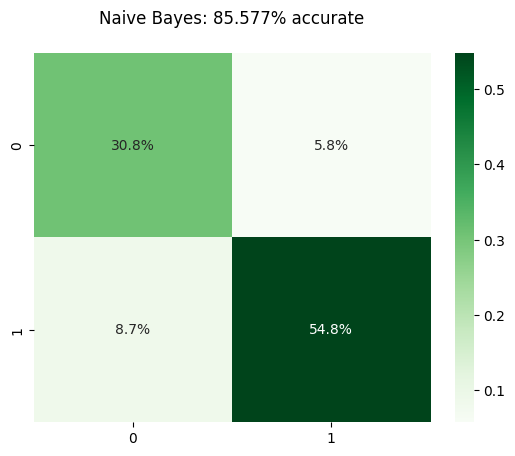

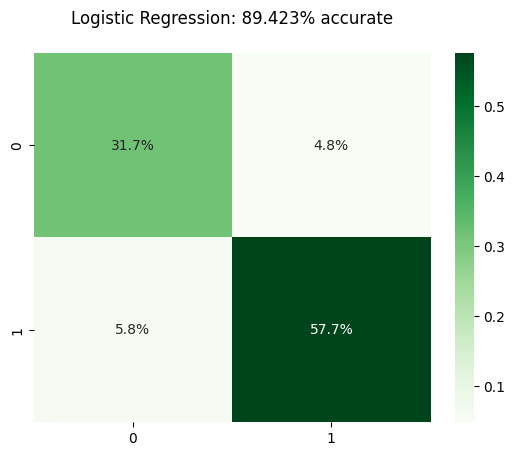

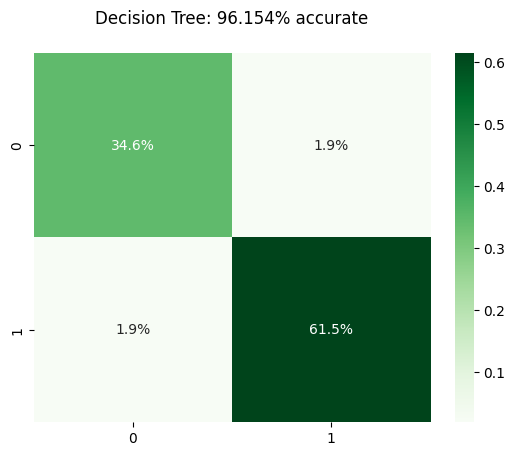

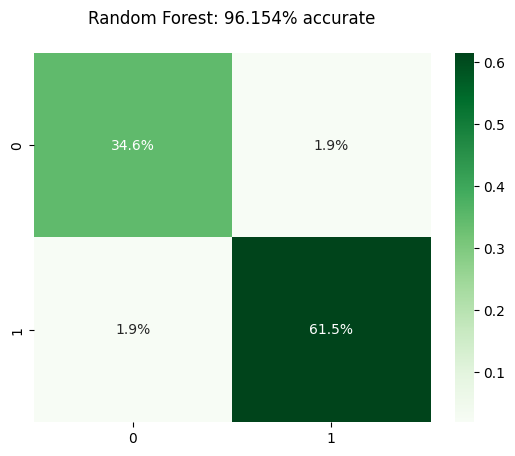

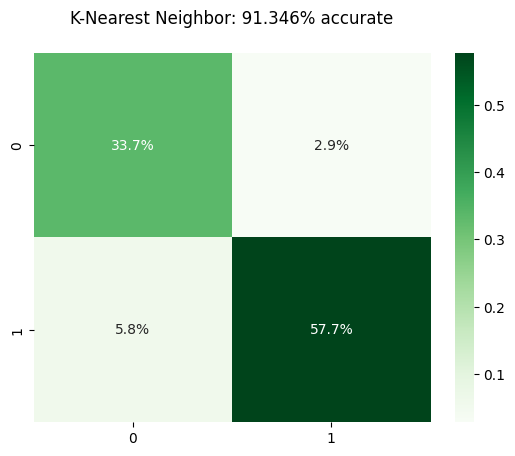

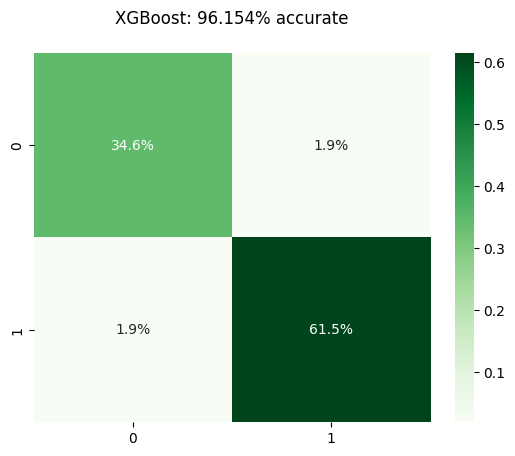

In [62]:
from sklearn.metrics import accuracy_score, confusion_matrix

results = {}

for index, model in enumerate(models):
    model.fit(x_train, y_train)
    predict = model.predict(x_test)
    confuse = confusion_matrix(y_test, predict)
    accur = accuracy_score(y_test, predict)
    results[models_name[index]] = accur * 100.0

    title = models_name[index] + ": " + "{:.3f}%".format(accur*100) + " accurate\n"
    ax = sns.heatmap(confuse/np.sum(confuse), annot=True, fmt='.1%', cmap="Greens")
    ax.set_title(title)
    plt.show()

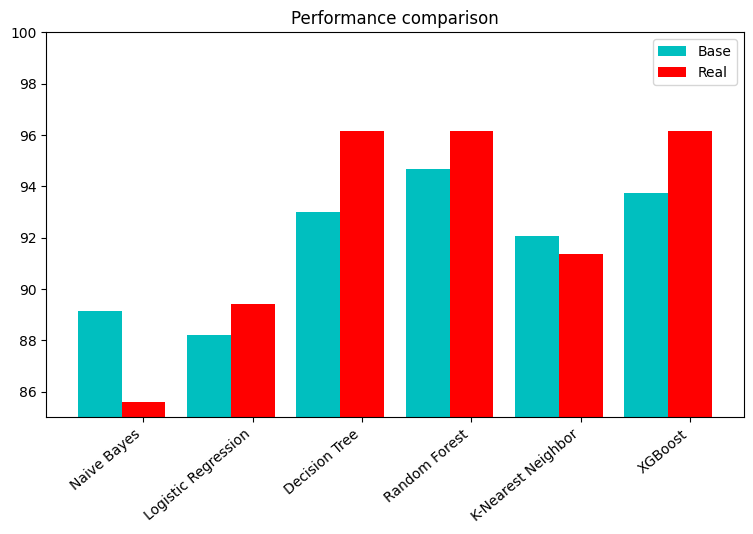

In [63]:
x = np.arange(len(results))

plt.figure(figsize=(9,5))
ax = plt.subplot(111)
ax.bar(x, results_base.values(), width=0.4, color="c", align="center")
ax.bar(x+0.4, results.values(), width=0.4, color="r", align="center")
ax.legend(("Base", "Real"))
plt.ylim((85, 100))
plt.xticks(x+0.4, results_base.keys())
plt.title("Performance comparison")
plt.xticks(rotation=40, horizontalalignment="right")
plt.show()

In [64]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

x = df[df.columns.difference(["status"])]
y = df["status"]

feat_chi = SelectKBest(score_func=chi2, k=10)
fit = feat_chi.fit(x, y)
feat_chi = pd.concat([pd.DataFrame(x.columns), pd.DataFrame(fit.scores_)], axis=1)
feat_chi.columns = ["column", "score"]
feat_chi = feat_chi.sort_values(by="score", ascending=False).reset_index(drop=False)
feat_chi = feat_chi[0:12]["column"].to_numpy()
print(feat_chi)

['polydipsia' 'polyuria' 'sudden_weight_loss' 'partial_paresis' 'gender'
 'irritability' 'polyphagia' 'alopecia' 'age' 'visual_blurring' 'weakness'
 'genital_thrush']


In [65]:
print(feat_corr)
print()
print("Difference:", list(set(feat_corr).symmetric_difference(set(feat_chi))))

['polyuria' 'polydipsia' 'gender' 'sudden_weight_loss' 'partial_paresis'
 'polyphagia' 'irritability' 'alopecia' 'visual_blurring' 'weakness']

Difference: ['age', 'genital_thrush']


In [66]:
x = df[feat_chi]
y = df["status"]

(x_train, x_test, y_train, y_test) = train_test_split(x, y, test_size = 0.2, random_state=1)

In [67]:
scl = StandardScaler()
x_train = scl.fit_transform(x_train)
x_test = scl.transform(x_test)

In [68]:
results_base = {}

for index, model in enumerate(models):
    cv = cross_val_score(model, x_train, y_train, cv=10)
    results_base[models_name[index]] = cv.mean() * 100.0
    print("Baseline using", models_name[index], "=", cv.mean() * 100.0, "%", "with std:", cv.std())

Baseline using Naive Bayes = 89.39024390243902 % with std: 0.05889375048349974
Baseline using Logistic Regression = 91.56213704994194 % with std: 0.049279874237066826
Baseline using Decision Tree = 94.94773519163765 % with std: 0.04744095759640703
Baseline using Random Forest = 97.32868757259003 % with std: 0.0317171005909904
Baseline using K-Nearest Neighbor = 92.5261324041812 % with std: 0.039855383092743224
Baseline using XGBoost = 96.13240418118467 % with std: 0.034903354973626885


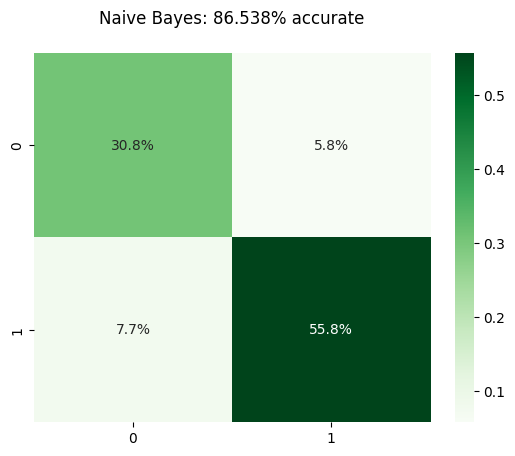

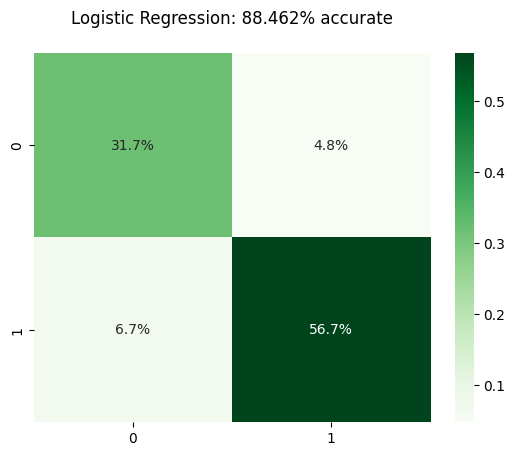

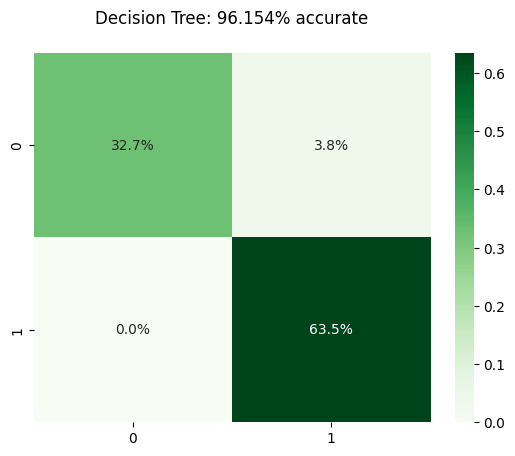

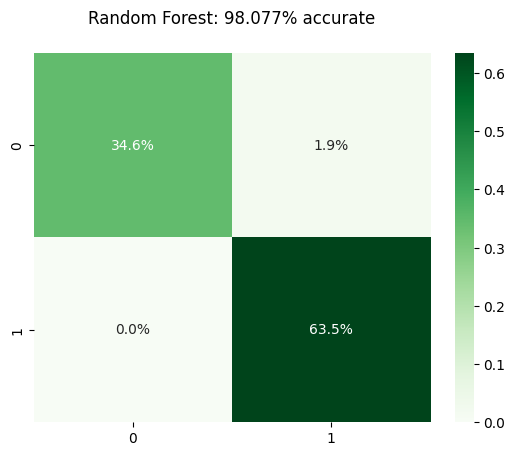

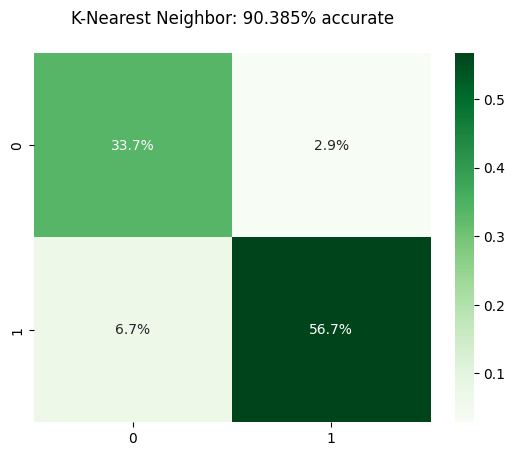

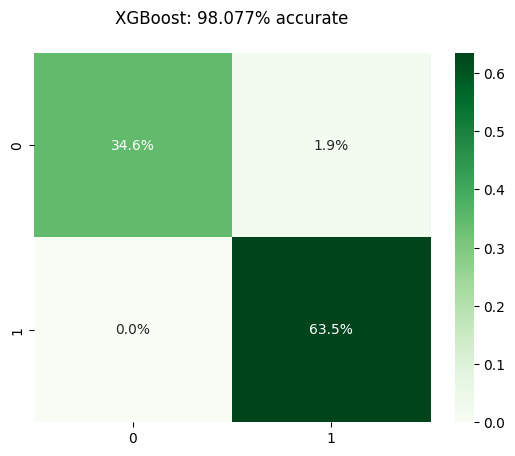

In [69]:
results = {}

for index, model in enumerate(models):
    model.fit(x_train, y_train)
    predict = model.predict(x_test)
    confuse = confusion_matrix(y_test, predict)
    accur = accuracy_score(y_test, predict)
    results[models_name[index]] = accur * 100.0

    title = models_name[index] + ": " + "{:.3f}%".format(accur*100) + " accurate\n"
    ax = sns.heatmap(confuse/np.sum(confuse), annot=True, fmt='.1%', cmap="Greens")
    ax.set_title(title)
    plt.show()

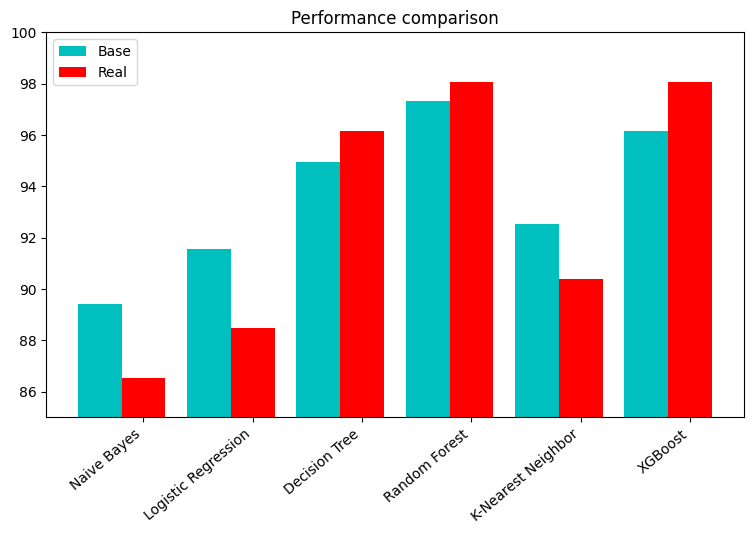

In [70]:
x = np.arange(len(results))

plt.figure(figsize=(9,5))
ax = plt.subplot(111)
ax.bar(x, results_base.values(), width=0.4, color="c", align="center")
ax.bar(x+0.4, results.values(), width=0.4, color="r", align="center")
ax.legend(("Base", "Real"))
plt.ylim((85, 100))
plt.xticks(x+0.4, results_base.keys())
plt.title("Performance comparison")
plt.xticks(rotation=40, horizontalalignment="right")
plt.show()